# point_defect_mobility - Methodology and code

__Python imports__

- [numpy](http://www.numpy.org/)
- [IPython](https://ipython.org)
- [atomman](https://github.com/usnistgov/atomman)
- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from pathlib import Path
import shutil
import datetime
from copy import deepcopy
from math import floor
from typing import Optional, Union, Tuple

# http://www.numpy.org/
import numpy as np
import numpy.typing as npt

# https://ipython.org/
from IPython.display import display, Markdown

import matplotlib.pyplot as plt

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc
from atomman.tools import filltemplate

# https://github.com/usnistgov/iprPy
import iprPy
from iprPy.tools import read_calc_file

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2024-04-25 using iprPy version 0.11.6


## 1. Load calculation and view description

### 1.1. Load the calculation

In [2]:
# Load the calculation being demoed
calculation = iprPy.load_calculation('point_defect_mobility')

### 1.2. Display calculation description and theory

In [3]:
# Display main docs and theory
display(Markdown(calculation.maindoc))
display(Markdown(calculation.theorydoc))

# point_defect_mobility calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Jacob Hechter** 

## Introduction

The point_defect_mobility calculation style uses a nudged elastic band (NEB) calculation to evaluate the energy barrier and path associated with point defects moving from one low energy configuration to another.

### Version notes

- 2019-8-09: Calculation created by Jacob Hechter.
- 2024-4-24: Calculation updated to current iprPy, and code and methodology cleaned up.

### Additional dependencies

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)
- NEB works best when exploring a single barrier path between two (meta)stable configurations.  If the end states are not local energy minima then they may transform into a different configuration so you should always check the initial and final configurations after relaxation.  If you see multiple energy peaks then the path involves more than one step that should be divided into separate NEB calculations to independently capture each barrier.
- The NEB calculation evaluates the energies as a function of reaction coordinates along the computed path.  The reaction coordinates come from the NEB algorithm and may not directly correspond to any actual physical coordinates.  For physical coordinates, it is better to use the measured position(s) of the NEB atom(s) instead.
- Intermediate replicas are held in place by applying a force on the NEB atoms based on a spring-like function.  NEB calculations can be sensitive to the associated spring constant, with optimum values often dependent on the specific calculation.  The weaker the spring constant, the more the replicas will preferentially relax towards the low energy end configurations.  The stronger the spring constant, the larger the "tension" will be between replicas that can cause the NEB path to deviate from the true minimum energy path.  




## Method and Theory

This calculation is designed to set up, run, and analyze a LAMMPS NEB calculation in which a single atom or a small number of atoms migrates from one low energy configuration to another. The primary use of such a calculation is to evaluate the path and energy barrier associated with a single migration jump of a point defect.

This calculation relies on the NEB method implemented in LAMMPS, as described here https://docs.lammps.org/neb.html.  In short, multiple replicas of the system are constructed to explore the transformation path from one low energy configuration to another low energy configuration.  The atoms in the system are divided into "non-NEB" atoms and "NEB" atoms; the non-NEB atoms will relax normally based on interatomic forces, while the NEB atoms have an additional spring-like force applied to them that keeps their positions intermediate between neighboring replicas.  This allows for the replicas to explore the transformation path between the two end states.

The NEB calculation involves two stages: a relaxation stage in which the replicas are allowed to simultaneously relax towards a minimum energy path, and a climbing stage in which the algorithm searches for the maximum energy along the path, i.e. the energy barrier.

### Defining the atomic configurations

Setting up the calculation requires defining the initial and final configurations and specifying which atoms in the system are NEB atoms and non-NEB atoms.  This is handled by the following parameters of the underlying point_defect_mobility() function

- __system__ is a full atomman.System that defines the non-NEB "background" atoms.
- __point_kwargs__ are atomman.defect.point() operations that can optionally be performed on system to modify the non-NEB atoms.  This is included largely as a convenience so that system can be a bulk crystal configuration for most simple point defect mobility investigations.
- __initialpos__ are the atomic positions of the NEB atoms in the initial reference state.  Atoms at these positions are added to the system to define the full initial configuration.
- __finalpos__ are the atomic positions of the NEB atoms in the final reference state.  Atoms at these positions are added to the system to define the full final configuration.
- __point_symbol__ lists the atom model symbols to associate with the NEB atoms.  Not needed if all atoms are the same species.

#### Example #1: Simple interstitial

With a simple interstitial, system can be a bulk crystal and then the initialpos and finalpos specify where the defect starts and ends.

#### Example #2: Vacancy

Vacancy mobility is actually the mobility of an atom into a nearby vacancy.  The non-NEB system should be a divacancy configuration in which the two vacancy positions correspond to the initialpos and finalpos locations.  This can easily be done with point_kwargs by providing a bulk crystal for system and then adding two vacancies with point_kwargs that have the same positions as initialpos and finalpos. 

#### Example #3: Frenkel-pair formation

The creation of a vacancy and a self-interstitial from a perfect crystal serves as a combination of the two previous examples.  The non-NEB configuration should have a single vacancy, then the initialpos and finalpos should correspond to the vacancy position and the interstitial position, respectively.

#### Example #4: Crowdion/dumbbell interstitials

Crowdion and other dumbbell interstitials are slightly more complicated in that they involve not just the addition of an atom interstitial but the substantial relaxation of at least one other atom in the system.  Other atoms may either need to be initially shifted to avoid overlapping, or multiple atoms can be listed in initialpos and finalpos to be managed by the NEB.  If multiple atoms are NEB controlled, don't forget to remove any duplicates from the non-NEB system.

#### Example #5: Complex environment

Point defect mobilities can also be investigated within more complex, non-bulk configurations.  Such investigations can be performed by providing a system with the more complex environment and using point_kwargs to delete any NEB atoms from the non-NEB list.

### Notes on obtaining good NEB results

- nreplicas sets the number of replica configurations to use.  The larger the number the more computationally expensive the calculation will be but the better the resolution of the path.  If you know the barrier to be symmetric, then using an odd number of replicas will position the middle replica near the barrier.

- springconst is the spring constant for the NEB force applied between replicas.  Weaker spring constants will allow the replicas to preferentially relax towards the low energy configurations and make the sampling of the high energy configurations more sparse.  Stronger spring constants increase the "tension" between replicas and may cause the NEB path to deviate from the true minimum energy path.  Selecting the optimum springconst value may require trial and error as the value is influenced by the path being explored, materials constants, and the number of replicas.

- Ideally, each NEB calculation should move from one low energy (meta)stable configuration to another through a single energy barrier.  If you run a calculation and see multiple barriers then it is recommended to run separate NEBs for each barrier jump by changing the end configurations to each intermediate minima.

- If the NEB calculation fails to converge within the minsteps/climbsteps, first check the replica configurations. 
    - Have the end configurations relaxed and transformed into a different type of configuration?
    - Are the NEB atom trajectories for the unrelaxed configurations doing something inappropriate, like passing through the position of another atom?
    - Are there multiple energy barriers indicating a complex multi-step path?

- If the path seems appropriate but convergence is still not reached, try different numbers of replicas and spring constant values.  
    - If you are only interested in the energy barrier value, then it is likely enough to find one (nreplicas, springconst) combination that converges.
    - If the specific path is important as well then you should explore the sensitivity of the path to the springconst.


## 2. Define calculation functions and generate files

This section defines the calculation functions and associated resource files exactly as they exist inside the iprPy package.  This allows for the code used to be directly visible and modifiable by anyone looking to see how it works.

### 2.1. point_defect_mobility()

This is the primary function for the calculation.  The version of this function built in iprPy can be accessed by calling the calc() method of an object of the associated calculation class.

In [4]:
def point_defect_mobility(lammps_command: str,
                          system: am.System,
                          potential: lmp.Potential,
                          neb_pos1: npt.ArrayLike,
                          neb_pos2: npt.ArrayLike,
                          mpi_command: Optional[str] = None,
                          neb_symbol: Union[str, list, None] = None,
                          numreplicas: int = 11,
                          partition: Optional[str] = None,
                          point_kwargs: Union[list, dict, None] = None,
                          etol: float = 0.0,
                          ftol: float = 0.0,
                          dmax: float = uc.set_in_units(0.01, 'angstrom'),
                          springconst: float = 5, 
                          thermosteps: int = 100,
                          dumpsteps: Optional[int] = None,
                          timestep: float = uc.set_in_units(0.01, 'ps'),
                          minsteps: int = 10000,
                          climbsteps: int = 10000):
    """
    Evaluates the mobility of point defects using NEB.

    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    system : atomman.System
        The system to perform the calculation on consisting of the atoms that
        are not to be subjected to the NEB forces.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    neb_pos1: array-like
        The position(s) of the atom(s) in the initial replica that are to be
        subjected to the NEB interaction forces.
    neb_pos2: array-like
        The position(s) of the atom(s) in the initial replica that are to be
        subjected to the NEB interaction forces.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    neb_symbol: str, list, or None, optional
        The potential symbol model to assign to each of the NEB atoms.  Value(s)
        are required unless all atoms of system are the same, in which the
        symbol(s) for the NEB atom(s) are inferred to also be the same.
    numreplicas : int, optional
        The number of NEB replicas to use.  Default value is 11.
    partition: str or None, optional
        The value for the LAMMPS command line partition option that should be
        of the form 'MxN' where M is the number of partitions (replicas) and
        N is the number of cores per replica.  If not given, this will default
        to M=numreplicas and N=1. 
    point_kwargs : dict, list of dict, or None, optional
        Any dictionaries containing the keyword arguments for the
        atomman.defect.point() function to modify the system with to alter the
        set of non-NEB atoms.   
    etol : float, optional
        The energy tolerance for the NEB  algorithm. This value is
        unitless. (Default is 0.0).
    ftol : float, optional
        The force tolerance for the NEB algorithm. This value is in
        units of force. (Default is 0.0).
    dmax : float, optional
        The maximum distance in length units that any atom is allowed to relax
        in any direction during a single minimization iteration (default is
        0.01 Angstroms).
    springconst : float, optional
        The NEB spring constant value to use.  Default value is 5.
    thermosteps : int, optional
        How often to output thermo data to the log.lammps files.  This is
        mostly useful for NEB runs to check convergence progress.  Default
        value is 100.
    dumpsteps : int or None, optional
        How often to generate dump configuration files for the replicas.
        Default value of None will set this to the max of (minsteps, climbsteps)
        so that only three states will be dumped: the initial unrelaxed, and the
        relaxed states at the end of the two NEB operations. 
    timestep : float, optional
        The timestep to use with the quickmin minimization algorithm.  Default
        value is 0.001 ps.
    minsteps : int, optional
        The maximum number of steps to perform during the NEB minimization
        operation.  Default value is 10000.
    climbsteps : int, optional
        The maximum number of steps to perform during the NEB climbing
        operation.  Default value is 10000.

    Returns
    -------
    dict
        Dictionary of results consisting of keys:
      
        - **'neb_coordinates'** (*numpy.ndarray*) - The final NEB reaction
          coordinates for each replica after both min and climb operations.
        - **'neb_energies'** (*numpy.ndarray*) - The final energies for
          each replica after both min and climb operations.
        - **'neb_positions'** (*numpy.ndarray*) - The final positions
          of each NEB atom in each replica after both min and climb operations.
        - **'forward_barrier'** (*float*) - The energy barrier for the forward
          reaction: difference between max energy and the first replica's energy.
        - **'reverse_barrier'** (*float*) - The energy barrier for the reverse
          reaction: difference between max energy and the last replica's energy.
    """

    # First check of pos values
    neb_pos1 = np.asarray(neb_pos1)
    if neb_pos1.shape == (3,):
        neb_pos1 = neb_pos1.reshape(1,3)
    if neb_pos1.ndim != 2 or neb_pos1.shape[1] != 3:
        raise ValueError('neb_pos1 must be an array of shape (3,) or (N,3)')

    neb_pos2 = np.asarray(neb_pos2)
    if neb_pos2.shape == (3,):
        neb_pos2 = neb_pos2.reshape(1,3)
    if neb_pos2.ndim != 2 or neb_pos2.shape[1] != 3:
        raise ValueError('neb_pos2 must be an array of shape (3,) or (N,3)')
    
    if neb_pos1.shape[0] != neb_pos2.shape[0]:
        raise ValueError('neb_pos1 and neb_pos2 must be the same length')

    # Safe copy system into firstsystem
    firstsystem = deepcopy(system)

    # Add point defect(s) to initial system if needed
    if point_kwargs is not None:
        if not isinstance(point_kwargs, (list, tuple)):
            point_kwargs = [point_kwargs]
        for pkwargs in point_kwargs:
            firstsystem = am.defect.point(firstsystem, **pkwargs)

    # Check symbols for the mobile atoms(s)
    if neb_symbol is None:
        if len(firstsystem.symbols) == 1:
            neb_symbol = firstsystem.symbols[0]
        else:
            raise ValueError('system has multiple atypes so symbol(s) must be specified for mobile atoms')
    if isinstance(neb_symbol, str):
        symbol = neb_symbol
        neb_symbol = [symbol for i in range(neb_pos1.shape[0])]
    elif len(neb_symbol) != neb_pos1.shape[0]:
        raise ValueError('neb_symbol not the same length as neb_pos1')
    
    # Match symbols and atypes
    atype = []
    symbols = list(firstsystem.symbols)
    for symbol in neb_symbol:
        if symbol not in symbols:
            symbols.append(symbol)
        atype.append(symbols.index(symbol) + 1)

    # Figure out atom ids for the mobile atoms
    min_a_id = firstsystem.natoms 
    max_a_id = min_a_id + neb_pos1.shape[0]
    a_ids = [i for i in range(min_a_id, max_a_id)]

    # Build Atoms objects for the mobile atoms
    atoms1 = am.Atoms(atype=atype, pos=neb_pos1)
    atoms2 = am.Atoms(atype=atype, pos=neb_pos2, a_id=a_ids)

    # Modify/build systems
    firstsystem = firstsystem.atoms_extend(atoms1, symbols=symbols)
    lastsystem = am.System(atoms=atoms2, box=firstsystem.box)
            
    # Run NEB
    neblog = neb(lammps_command, firstsystem, lastsystem, potential,
                 mpi_command=mpi_command, partition=partition,
                 id_key='a_id', id_start0=True,
                 etol=etol, ftol=ftol, dmax=dmax, numreplicas=numreplicas,
                 springconst=springconst, thermosteps=thermosteps,
                 dumpsteps=dumpsteps, timestep=timestep, minsteps=minsteps,
                 climbsteps=climbsteps)

    # Get final step and NEB path values at that step
    finalstep = neblog.climbrun.Step.values[-1]
    coord, energy = neblog.get_neb_path(finalstep)
    
    # Add final path and barrier 
    results = {}
    results['neb_coordinates'] = coord
    results['neb_energies'] = energy

    # Get the moving atom positions for each replica
    moving_pos = np.empty((len(a_ids), numreplicas, 3))
    for r in range(numreplicas):
        replica = am.load('atom_dump', f'step-{finalstep}.replica-{r+1}.dump')    
        for i, a_id in enumerate(a_ids):
            moving_pos[i, r, :] = replica.atoms.pos[a_id, :]
    results['neb_positions'] = moving_pos

    # Add barrier energies
    results['forward_barrier'] = neblog.get_barrier()
    results['reverse_barrier'] = neblog.get_barrier(reverse=True)

    return results

### 2.2. neb

In [5]:
def neb(lammps_command: str,
        firstsystem: am.System,
        lastsystem: am.System,
        potential: lmp.Potential,
        mpi_command: Optional[str] = None,
        numreplicas: int = 11, 
        partition: Optional[str] = None,
        id_key: Optional[str] = None,
        id_start0: bool = True,
        etol: float = 0.0,
        ftol: float = 0.0,
        dmax: float = uc.set_in_units(0.01, 'angstrom'),
        springconst: float = 5, 
        thermosteps: int = 100,
        dumpsteps: Optional[int] = None, 
        timestep: float = uc.set_in_units(0.01, 'ps'),
        minsteps: int = 10000,
        climbsteps: int = 10000) -> dict:
    """
    Sets up and runs the neb.template LAMMPS script for performing an NEB
    calculation between two configurations.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    firstsystem : atomman.System
        The system configuration corresponding to the first replica.  This
        should be a full system that defines the box and all atoms.
    lastsystem : atomman.System
        The system configuration corresponding to the final replica.  No
        box information is used, and only the atoms to subject to NEB forces
        need to be included.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    numreplicas : int, optional
        The number of NEB replicas to use.  Default value is 11.
    partition: str or None, optional
        The value for the LAMMPS command line partition option that should be
        of the form 'MxN' where M is the number of partitions (replicas) and
        N is the number of cores per replica.  If not given, this will default
        to M=numreplicas and N=1. 
    id_key : str or None, optional
        The name of the atoms property of lastsystem to match the contained
        NEB atoms to those in firstsystem.  A default value of None will use
        the atom array indices meaning that either all atoms need to be in
        lastsystem or that the first atom(s) in firstsystem are the NEB atoms.
    id_start0 : bool, optional
        A value of True (default) indicates that the id_key values are relative
        to an array that starts at 0 as in the case of atomman atom indices.  A
        value of False indicates that the id_key values are relative to an array
        that starts at 1 as in the case of the LAMMPS atom id values.
    etol : float, optional
        The energy tolerance for the NEB  algorithm. This value is
        unitless. (Default is 0.0).
    ftol : float, optional
        The force tolerance for the NEB algorithm. This value is in
        units of force. (Default is 0.0).
    dmax : float, optional
        The maximum distance in length units that any atom is allowed to relax
        in any direction during a single minimization iteration (default is
        0.01 Angstroms).
    springconst : float, optional
        The NEB spring constant value to use.  Default value is 5.
    thermosteps : int, optional
        How often to output thermo data to the log.lammps files.  This is
        mostly useful for NEB runs to check convergence progress.  Default
        value is 100.
    dumpsteps : int or None, optional
        How often to generate dump configuration files for the replicas.
        Default value of None will set this to the max of (minsteps, climbsteps)
        so that only three states will be dumped: the initial unrelaxed, and the
        relaxed states at the end of the two NEB operations. 
    timestep : float, optional
        The timestep to use with the quickmin minimization algorithm.  Default
        value is 0.01 ps.
    minsteps : int, optional
        The maximum number of steps to perform during the NEB minimization
        operation.  Default value is 10000.
    climbsteps : int, optional
        The maximum number of steps to perform during the NEB climbing
        operation.  Default value is 10000.

    Returns
    -------
    atomman.lammps.NEBLog
        The collection of all thermo and NEB data from within all of the
        log.lammps values for both individual replicas and the overall NEB
        run.
    """
    
    # Dump the two systems
    system_pair_info = firstsystem.dump('atom_data', f='init.dat',
                                           potential=potential)
    lastsystem.dump('neb_replica', f='final.dat',
                     id_key=id_key, id_start0=id_start0)

    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)
    force_per_length = f"{lammps_units['force']}/{lammps_units['length']}"
    
    # Get lammps version date
    lammps_date = lmp.checkversion(lammps_command)['date']
    
    # Set default dumpsteps
    if dumpsteps is None:
        dumpsteps = max(minsteps, climbsteps)

    # Define lammps variables
    lammps_variables = {}
    
    lammps_variables['atomman_system_pair_info'] = system_pair_info
    lammps_variables['numreplicas'] = numreplicas
    lammps_variables['springconst'] = uc.get_in_units(springconst, force_per_length)
    lammps_variables['thermosteps'] = thermosteps
    lammps_variables['dumpsteps'] = dumpsteps
    lammps_variables['timestep'] = uc.get_in_units(timestep, lammps_units['time'])
    lammps_variables['minsteps'] = minsteps
    lammps_variables['climbsteps'] = climbsteps
    lammps_variables['dmax'] = uc.get_in_units(dmax, lammps_units['length'])
    lammps_variables['etol'] = etol
    lammps_variables['ftol'] = uc.get_in_units(ftol, lammps_units['force'])
    lammps_variables['final_system'] = 'final.dat'
    
    # Set dump_modify_format based on lammps_date
    if lammps_date < datetime.date(2016, 8, 3):
        lammps_variables['dump_modify_format'] = '"%d %d %.13e %.13e %.13e %.13e %.13e %.13e %.13e"'
    else:
        lammps_variables['dump_modify_format'] = 'float %.13e'
    
    # Write lammps input script
    lammps_script = 'neb_lammps.in'
    template = read_calc_file('iprPy.calculation.point_defect_mobility',
                              'neb_lammps.template')
    with open(lammps_script, 'w') as f:
        f.write(filltemplate(template, lammps_variables, '<', '>'))
    
    # Add the partition option to the LAMMPS command
    if partition is None:
        partition = f'{numreplicas}x1'
    lammps_command_p = f'{lammps_command} -p {partition}' 

    # Run the calc_neb
    output = lmp.run(lammps_command_p, script_name=lammps_script,
                     mpi_command=mpi_command, screen=False)
    neblog = lmp.NEBLog()

    return neblog

### 2.3. min.template file

In [6]:
with open('neb_lammps.template', 'w') as f:
    f.write("""# LAMMPS input script for neb calculations

# NEB parameters
variable numreplicas equal <numreplicas>
variable springconst equal <springconst>

# Run parameters
variable thermosteps equal <thermosteps>
variable dumpsteps equal <dumpsteps>
variable timestep equal <timestep>

# Relaxation parameters
variable minsteps equal <minsteps>
variable climbsteps equal <climbsteps>
variable dmax equal <dmax>
variable etol equal <etol>
variable ftol equal <ftol>

# LAMMPS setting parameters
box tilt large
atom_modify map array

# potential and initial system definition
<atomman_system_pair_info>

# property compute definitions
compute peatom all pe/atom

# define neb
fix neb all neb ${springconst}

# dump file definition
variable i uloop ${numreplicas}
dump dumpy all custom ${dumpsteps} step-*.replica-${i}.dump id type x y z c_peatom
dump_modify dumpy format float %.13e

# thermo definition
thermo ${thermosteps}
thermo_style custom step lx ly lz pe
thermo_modify format float %.13e

# minimization definition
timestep ${timestep}
min_style quickmin
min_modify dmax ${dmax}

# run neb
neb ${etol} ${ftol} ${minsteps} ${climbsteps} ${thermosteps} final <final_system>""")

## 3. Specify input parameters

### 3.1. System-specific paths

- __lammps_command__ is the LAMMPS command to use (required).
- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.

In [7]:
lammps_command = '/home/lmh1/LAMMPS/2022-06-23/src/lmp_mpi'
mpi_command = 'mpiexec -n 11'

# Optional: check that LAMMPS works and show its version 
print(f'LAMMPS version = {am.lammps.checkversion(lammps_command)["version"]}')

LAMMPS version = 23 Jun 2022


### 3.2. Interatomic potential

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for the calculation.  
- __potential__ is an atomman.lammps.Potential object (required).

In [8]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'

# Retrieve potential and parameter file(s) using atomman
potential = am.load_lammps_potential(id=potential_name, getfiles=True)

### 3.3. Initial unit cell system

- __ucell__ is an atomman.System representing a fundamental unit cell of the system (required).  Here, this is generated using the load parameters and symbols.

In [9]:
# Create ucell by loading prototype record
ucell = am.load('crystal', potential=potential, family='A1--Cu--fcc')

print(ucell)

Multiple matching record retrieved from local
#  family               symbols  alat    Ecoh    method  standing
 1 A1--Cu--fcc          Ni        3.5200 -4.4500 dynamic good
 2 A1--Cu--fcc          Ni        7.3760  0.0119 dynamic good


Please select one: 1


avect =  [ 3.520,  0.000,  0.000]
bvect =  [ 0.000,  3.520,  0.000]
cvect =  [ 0.000,  0.000,  3.520]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ni',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.760 |   1.760
      2 |       1 |   1.760 |   0.000 |   1.760
      3 |       1 |   1.760 |   1.760 |   0.000


### 3.4 Defect parameters

- __neb_pos1__ (required) gives positions for the atoms in the first replica that are to be subjected to NEB forces.
- __neb_pos2__ (required) gives positions for the atoms in the last replica that are to be subjected to NEB forces.
- __neb_symbol__ (optional) the potential model symbols for the NEB atoms.  This is optional if all atoms, both NEB and non-NEB, are the same element as it can be inferred.
- __point_kwargs__ (optional) is a dictionary or list of dictionaries containing parameters for generating defects in the non-NEB background system. Allowed keywords are:
    - __ptd_type__ indicates which defect type to generate: 'v' for vacancy, 'i' for interstitial, 's' for substitutional, or 'db' for dumbbell.
    - __atype__ is the atom type to assign to the defect atom ('i', 's', 'db' ptd_types).  
    - __pos__ specifies the position for adding the defect atom (all ptd_types).
    - __ptd_id__ specifies the id of an atom in the initial system where the defect is to be added. Alternative to using pos ('v', 's', 'db' ptd_types).
    - __db_vect__ gives the vector associated with the dumbbell interstitial to generate ('db' ptd_type).
    - __scale__ indicates if pos and db_vect are in absolute (False) or box-relative (True) coordinates. Default is False.
    - __atol__ is the absolute tolerance for position-based searching. Default is 1e-3 angstroms.

In [10]:
# Parameters for vacancy to vacancy NEB in an fcc cell
# Non-NEB system should have two vacancies
# The one NEB atom should jump from one vacancy site to the other

# Specify the end locations of the NEB atom and what symbol it is
neb_pos1 = ucell.box.position_relative_to_cartesian([1.0, 0.0, 0.0])    # [0.0, 0.0, 0.0] site shifted by a
neb_pos2 = ucell.box.position_relative_to_cartesian([1.0, 0.5, 0.5])    # [0.0, 0.5, 0.5] site shifted by a
neb_symbol = 'Ni'

# Add vacancies to the non-NEB system at the two NEB end locations
point_kwargs = [{'ptd_type': 'v', 'pos': neb_pos1,},
                {'ptd_type': 'v', 'pos': neb_pos2,}]

### 3.5. System modifications

- __sizemults__ list of three integers specifying how many times the ucell vectors of $a$, $b$ and $c$ are replicated in creating system.
- __system__ is an atomman.System to perform the scan on (required). 

In [11]:
sizemults = [12, 12, 12]

# Generate system by supersizing ucell
system = ucell.supersize(*sizemults)
print('# of atoms in system =', system.natoms)

# of atoms in system = 6912


### 3.6 Calculation-specific parameters

- __numreplicas__ is the number of NEB replicas to use.  Default value is 11.
- __partition__ gives the value for the LAMMPS command line -partition option.  The value should be a str of form 'MxN' where M=numreplicas and N is the number of cores to use for each replica.  The default value of None will use M=numreplicas and N=1.
- __springconst__ is the NEB spring constant to use.  This is in force/length units and has a default value of 5 eV/angstrom^2.
- __energytolerance__ is the energy tolerance to use during the NEB. This is unitless.
- __forcetolerance__ is the force tolerance to use during the NEB. This is in energy/length units.
- __maxatommotion__ is the largest distance that an atom is allowed to move during a minimization iteration. This is in length units and has a default value of 0.01 angstom.
- __minsteps__ is the maximum number of NEB relaxation steps to perform.  Default value is 10000.
- __climbsteps__ is the maximum number of NEB climbing steps to perform.  Default value is 10000.
- __timestep__ is the timestep to use with the NEB minimization algorithm.  This should be about 10x the timestep of MD calculations. Default value is 0.01 ps.
- __thermosteps__ indicates how often thermo data is outputted.  Default value is 100.
- __dumpsteps__ indicates how often atomic dump files are generated.  The default value of None sets this to the max of (minsteps, climbsteps) so configurations are only saved for the initial state and the final states of the min/climb operations.


In [12]:
numreplicas = 11
partition = None
springconst = uc.set_in_units(5, 'eV/angstrom^2')

energytolerance = 0.0
forcetolerance = uc.set_in_units(1e-6, 'eV/angstrom')
maxatommotion = uc.set_in_units(0.01, 'angstrom')
 
thermosteps = 100
dumpsteps = None
timestep = uc.set_in_units(0.01, 'ps')
minsteps = 10000
climbsteps = 10000

## 4. Run calculation and view results

### 4.1. Run calculation

All primary calculation method functions take a series of inputs and return a dictionary of outputs.

In [13]:
results_dict = point_defect_mobility(lammps_command, system, potential, neb_pos1, neb_pos2,
                                     mpi_command=mpi_command,
                                     neb_symbol=neb_symbol,
                                     numreplicas=numreplicas,
                                     partition=partition,
                                     point_kwargs=point_kwargs,
                                     etol=energytolerance,
                                     ftol=forcetolerance,
                                     dmax=maxatommotion,
                                     springconst=springconst, 
                                     thermosteps=thermosteps,
                                     dumpsteps=dumpsteps,
                                     timestep=timestep,
                                     minsteps=minsteps,
                                     climbsteps=climbsteps)
print(results_dict.keys())

dict_keys(['neb_coordinates', 'neb_energies', 'neb_positions', 'forward_barrier', 'reverse_barrier'])


### 4.2. Report results

Values returned in the results_dict:

- **'neb_coordinates'** (*numpy.ndarray*) - The final NEB reaction coordinates for each replica after both min and climb operations.
- **'neb_energies'** (*numpy.ndarray*) - The final energies for each replica after both min and climb operations.
- **'neb_positions'** (*numpy.ndarray*) - The final positions of each NEB atom in each replica after both min and climb operations.
- **'forward_barrier'** (*float*) - The energy barrier for the forward reaction: difference between max energy and the first replica's.
- **'reverse_barrier'** (*float*) - The energy barrier for the reverse reaction: difference between max energy and the last replica's defects.

In [14]:
energy_unit = 'eV'
length_unit = 'angstrom'

print('forward_barrier =', uc.get_in_units(results_dict['forward_barrier'], energy_unit), energy_unit)
print('reverse_barrier =', uc.get_in_units(results_dict['reverse_barrier'], energy_unit), energy_unit)

forward_barrier = 1.289454935998947 eV
reverse_barrier = 1.289454935998947 eV


Plot the energies as a function of the reaction coordinates

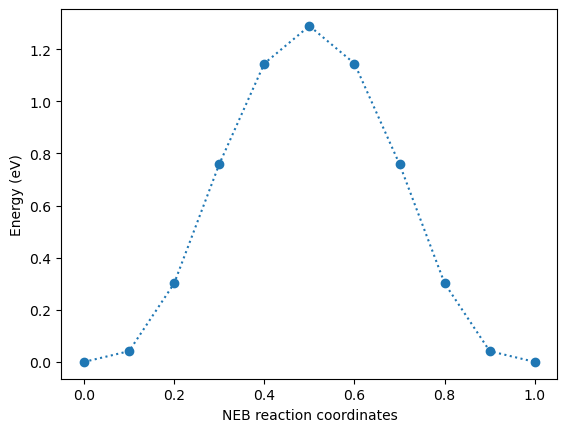

In [15]:
x = results_dict['neb_coordinates']
y = uc.get_in_units(results_dict['neb_energies'], energy_unit)
plt.plot(x, y, 'o:')

plt.xlabel('NEB reaction coordinates')
plt.ylabel('Energy (eV)')
plt.show()

Show the NEB atom positions across the replicas

In [16]:
results_dict['neb_positions']

array([[[3.51999944, 0.01051564, 0.01051564],
        [3.51999944, 0.08326119, 0.08326119],
        [3.51999944, 0.25496158, 0.25496158],
        [3.51999943, 0.45713518, 0.45713518],
        [3.51999944, 0.66712604, 0.66712604],
        [3.51999944, 0.87999986, 0.87999986],
        [3.51999944, 1.09287367, 1.09287367],
        [3.51999943, 1.30286454, 1.30286454],
        [3.51999944, 1.50503814, 1.50503814],
        [3.51999944, 1.67673853, 1.67673853],
        [3.51999944, 1.74948408, 1.74948408]]])

Plot the barrier energy versus distance that the NEB atom has moved

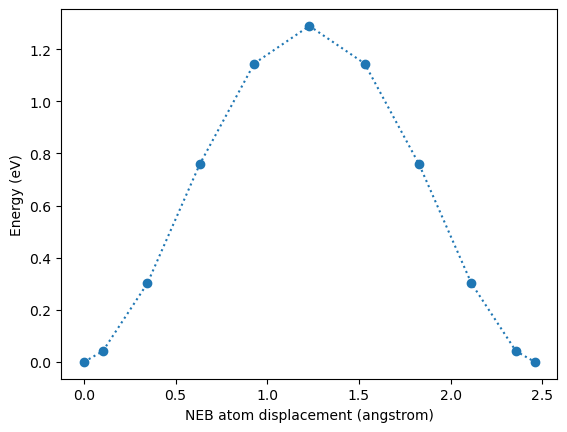

In [17]:
dmag = system.dmag(results_dict['neb_positions'][0,0], results_dict['neb_positions'][0])
x = uc.get_in_units(dmag, length_unit)

y = uc.get_in_units(results_dict['neb_energies'], energy_unit)
plt.plot(x, y, 'o:')

plt.xlabel('NEB atom displacement (angstrom)')
plt.ylabel('Energy (eV)')
plt.show()